In [14]:
import mne
from mne.preprocessing import ICA
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.signal import iirnotch, filtfilt, butter, welch
from scipy.stats import kurtosis, skew
from scipy.stats import f_oneway
import pywt
import antropy as ant
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# The following two cells showcases that converting faulty SET files to EDF manually through EEGLAB manages to get them open, however, the bottom line is faulty.

In [3]:
raw = mne.io.read_raw_eeglab('sub-01/ses-2/eeg/sub-01_ses-2_task-eyesopen_eeg.set', preload=True)
raw.describe()
print(raw.ch_names)

# RESULT = RuntimeError: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers

Reading C:\Users\Simeon\Desktop\UNI\YEAR 3\SEM 2\Thesis\Dataset\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Reading 0 ... 113956  =      0.000 ...   227.912 secs...


C:\Users\Simeon\AppData\Local\Temp\ipykernel_31684\962406321.py:1: RuntimeWarning: Data file name in EEG.data (test1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-01_ses-2_task-eyesopen_eeg.fdt).
  raw = mne.io.read_raw_eeglab('sub-01/ses-2/eeg/sub-01_ses-2_task-eyesopen_eeg.set', preload=True)


<RawEEGLAB | sub-01_ses-2_task-eyesopen_eeg.fdt, 61 x 113957 (227.9 s), ~53.1 MiB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV      -124.60     -47.20     -18.70       3.50     178.70
 1  AF3   EEG   µV       -76.20     -23.50     -10.40       2.10     112.70
 2  AF7   EEG   µV       -80.70     -40.20     -29.80     -20.60     104.50
 3  Fz    EEG   µV       -26.00      -9.80      -4.70       0.40      47.60
 4  F1    EEG   µV       -32.50     -14.20      -8.20      -2.80      30.30
 5  F3    EEG   µV       -42.60     -14.30      -6.50       0.50      43.10
 6  F5    EEG   µV       -77.50     -28.70     -10.40       6.20     105.10
 7  F7    EEG   µV      -140.90     -14.80       2.80      24.00      93.40
 8  FC1   EEG   µV       -29.90     -11.90      -7.00      -2.70      12.10
 9  FC3   EEG   µV       -35.80     -15.80      -7.40       0.00      25.50
10  FC5   EEG   µV      -275.40     -40.80     -12.70       9.20    

In [5]:
# It works after faulty SET files being converted to EDF files manually thorugh EEGLAB
# BUT THIS PRODUCES FAULTY BOTTOM LINE (MIN)
raw = mne.io.read_raw_edf('sub-01/ses-2/eeg/new.edf', preload=True)
raw.describe()
print(raw.ch_names)

Extracting EDF parameters from C:\Users\Simeon\Desktop\UNI\YEAR 3\SEM 2\Thesis\Dataset\sub-01\ses-2\eeg\new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 113999  =      0.000 ...   227.998 secs...
<RawEDF | new.edf, 61 x 114000 (228.0 s), ~53.1 MiB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV      -299.80     -47.30     -18.70       3.40     178.70
 1  AF3   EEG   µV      -299.80     -23.50     -10.40       2.10     112.70
 2  AF7   EEG   µV      -299.80     -40.30     -29.80     -20.60     104.50
 3  Fz    EEG   µV      -299.80      -9.80      -4.70       0.40      47.60
 4  F1    EEG   µV      -299.80     -14.20      -8.20      -2.80      30.30
 5  F3    EEG   µV      -299.80     -14.40      -6.50       0.40      43.10
 6  F5    EEG   µV      -299.80     -28.80     -10.40       6.20     105.10
 7  F7    EEG   µV      -299.80     -14.90       2.80      24.00      9

# The solution to this problem is opening the lone .set file in EEGLAB, then manually going through "SAVE CURRENT DATASET AS" and re-saving it as .set. This fixes the bottom line, whereby producing a combo of .set and .fdt files. #


# The following two cells open a functional SET file in its original format and then manually saved to SET (whereby creating also an FDT) to showcase that no changes to the data is being made.

In [7]:
# Functional SET
raw = mne.io.read_raw_eeglab('sub-02/ses-1/eeg/sub-02_ses-1_task-eyesopen_eeg.set', preload=True)
raw.describe()
print(raw.ch_names)

Reading C:\Users\Simeon\Desktop\UNI\YEAR 3\SEM 2\Thesis\Dataset\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
<RawEEGLAB | sub-02_ses-1_task-eyesopen_eeg.fdt, 61 x 150000 (300.0 s), ~69.9 MiB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV      -232.90      -6.50      13.10      33.00     320.80
 1  AF3   EEG   µV      -379.20     -43.50     -26.40     -10.00     308.80
 2  AF7   EEG   µV      -400.40      -5.80      20.30      45.50     473.10
 3  Fz    EEG   µV      -919.30     -30.10     -15.00       2.10     361.70
 4  F1    EEG   µV      -113.40       2.70      25.20      48.50     260.10
 5  F3    EEG   µV      -539.80      -1.90      17.50      36.60     576.60
 6  F5    EEG   µV      -929.50      -9.40       6.90      21.40     381.20
 7  F7    EEG   µV     -1011.70     -40.90     -20.50      -1.10     487.50
 8  FC1   EEG   µV      -167.60     -21.60     

In [8]:
# Manually re-saved functional SET changes no data
raw = mne.io.read_raw_eeglab('sub-02/ses-1/eeg/test.set', preload=False)
raw.describe()
print(raw.ch_names)

Reading C:\Users\Simeon\Desktop\UNI\YEAR 3\SEM 2\Thesis\Dataset\sub-02\ses-1\eeg\test.fdt
<RawEEGLAB | test.fdt, 61 x 150000 (300.0 s), ~72 KiB, data not loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fp1   EEG   µV      -232.90      -6.50      13.10      33.00     320.80
 1  AF3   EEG   µV      -379.20     -43.50     -26.40     -10.00     308.80
 2  AF7   EEG   µV      -400.40      -5.80      20.30      45.50     473.10
 3  Fz    EEG   µV      -919.30     -30.10     -15.00       2.10     361.70
 4  F1    EEG   µV      -113.40       2.70      25.20      48.50     260.10
 5  F3    EEG   µV      -539.80      -1.90      17.50      36.60     576.60
 6  F5    EEG   µV      -929.50      -9.40       6.90      21.40     381.20
 7  F7    EEG   µV     -1011.70     -40.90     -20.50      -1.10     487.50
 8  FC1   EEG   µV      -167.60     -21.60      -0.60      24.10     288.70
 9  FC3   EEG   µV      -689.00     -16.90      13.10      30.60     768.70
10

### Beginning of preprocessing ###
Here, a dictionary is created that contains the order for the sessions and conditions.

In [3]:
# Create a mapping for each session, for each subject
def session_mapping(file='participants.tsv', column_order="SessionOrder"):
    # Create a dictionary to store mapping for each session for each subject
    sub_ses_order = {}
    # Read the TSV file with sep = '\t'
    df = pd.read_csv(file, sep='\t')
    
    # Go through each row and get the mapping (NS->SD / SD->NS)
    for i, subject in enumerate(df[column_order]):
        list_1_2 = subject.split("->")
        subject_number = i+1 # This is done to properly type up single digit and double digits subject names
        if subject_number < 10:
            sub_ses_order[f"sub-0{subject_number}"] = {f"ses-1":list_1_2[0], f"ses-2":list_1_2[1]}
        else:
            sub_ses_order[f"sub-{subject_number}"] = {f"ses-1":list_1_2[0], f"ses-2":list_1_2[1]}
    
    # Return result
    return sub_ses_order

session_mapping = session_mapping()

In [4]:
for key, value in session_mapping.items():
    print(key, value)
    break

sub-01 {'ses-1': 'NS', 'ses-2': 'SD'}


Here the feature extraction functions for the raw EEG data are defined.

In [6]:
def band_powers_ratios(raw_frame, explicit=True): # raw frame is 2000x61
    
    raw_frame = raw_frame.T # here it gets transposed to 61x2000 so that welch can be run on the entire dataframe
    
    freqs, psd = welch(raw_frame, fs=500, nperseg=500, axis=1)

    freq_bands = {
        "Delta": [1, 4], 
        "Theta": [4, 8],
        "Alpha": [8, 13],
        "Beta":  [13, 30],
        "Gamma": [30, 45]
        }

    # Calculate global average band power for entire 4s sample
    powers = {}
    for band, (l, h) in freq_bands.items():
        mask = (freqs >= l) & (freqs <= h)
        # Take average across both frequencies and channel dimensions to generate a single global average band power value
        powers[band] = 10 * np.log10(np.mean(psd[:, mask]) + 1e-12)  # Avoid log(0) and convert to decibel (standard for PSD)
    
    # Calculate ratios between global average band powers
    ratios = {
        f"{b1}/{b2}": powers[b1] / powers[b2]
        for i, b1 in enumerate(powers)
        for j, b2 in enumerate(powers)
        if i != j
    }
    
    merged = powers | ratios
    merged_dataframe = pd.DataFrame([merged])
    
    if explicit:
        print(merged_dataframe.shape)
        print(merged_dataframe)
        
    return merged_dataframe


# Discrete Wavelet Transform
def db_wavelet_features(raw_frame, wavelet="db4", level=4, explicit=True): # raw frame is 2000x61
    raw_frame = raw_frame.T # transposed frame is 61x2000
    features = []
    # Perform Discrete Wavelet Transform using Daubechies
    coefs = pywt.wavedec(raw_frame, wavelet=wavelet, level=level)
    for i, c in reversed(list(enumerate(coefs))):
        features.extend([
            np.sqrt(np.mean(np.square(c))),
            kurtosis(c.flatten()),
            skew(c.flatten())
        ])
        
    # Extracting global wavelet entropy
    
    # Calcuate energy per wavelet
    energies = np.array([np.sum(np.square(c)) for c in coefs])
    # See how much they contribute to the overall signal
    distribution = energies / (np.sum(energies)+1e-12)
    # Calculate Shannon entropy on the distribution
    entropy = -np.sum(distribution * (np.log2(distribution)+1e-12))
    features.append(entropy) 
    
    # Generate feature labels
    labels = []
    labels.extend(["cA4_RMS", "cA4_kurtosis", "cA4_skew"])
    labels.extend([f"cD{i}_{metric}" for i in range(4,0,-1) for metric in ["RMS", "kurtosis", "skew"]])
    labels.append("wavelet_entropy")
    
    # Combine the data with the labels to create a dataframe
    final = pd.DataFrame(data=[features], columns=labels)

    if explicit:
        print(final.shape)
        print(final)
    
    return final

def other_metrics(raw_frame, explicit=True):
    head_sections = {
        "frontal": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 60],
        "central": [11, 12, 13, 14, 15, 41, 42, 43, 44],
        "temporal": [16, 20, 21, 45, 50, 51],
        "parietal": [17, 18, 19, 22, 23, 24, 25, 26, 46, 47, 48, 49, 52, 53, 54, 55],
        "occipital": [27, 28, 29, 30, 56, 57, 58, 59]
    }
    
    # Transpose the data so electrodes are rows (61) and time points are columns (2000)
    raw_frame = raw_frame.T
    
    features = []
    labels = []
    passes = []
    
    # Global metrics (across all electrodes)
    # Spectral entropy - calculate for each electrode, then average
    spectral_entropies = []
    for i in range(raw_frame.shape[0]):
        try:
            spectral_entropies.append(ant.spectral_entropy(raw_frame.iloc[i, :], sf=500))
        except:
            passes.append(f"Spectral entropy pass at i={i}")
    features.append(np.mean(spectral_entropies) if spectral_entropies else np.nan)
    
    # Permutation entropy - calculate for each electrode, then average
    perm_entropies = []
    for i in range(raw_frame.shape[0]):
        try:
            perm_entropies.append(ant.perm_entropy(raw_frame.iloc[i, :]))
        except:
            passes.append(f"Permutation entropy pass at i={i}")
    features.append(np.mean(perm_entropies) if perm_entropies else np.nan)
    
    # Hjorth mobility and complexity - calculate for each electrode, then average
    mobility_values = []
    complexity_values = []
    for i in range(raw_frame.shape[0]):
        try:
            m, c = ant.hjorth_params(raw_frame.iloc[i, :])
            mobility_values.append(m)
            complexity_values.append(c)
        except:
            passes.append(f"Hjorth pass at i={i}")
    features.append(np.mean(mobility_values) if mobility_values else np.nan)
    features.append(np.mean(complexity_values) if complexity_values else np.nan)
    
    # Zero crossings - calculate for each electrode, then average
    zero_crossings = []
    for i in range(raw_frame.shape[0]):
        try:
            zero_crossings.append(ant.num_zerocross(raw_frame.iloc[i, :]))
        except:
            passes.append(f"Zero crossings pass at i={i}")
    features.append(np.mean(zero_crossings) if zero_crossings else np.nan)
    
    # Process each head section
    for section, indices in head_sections.items():
        # Process metrics for electrodes in this section
        sample_entropies = []
        higuchi_values = []
        dfa_values = []
        spectral_entropies_section = []
        perm_entropies_section = []
        mobility_section = []
        complexity_section = []
        zero_crossings_section = []
        
        for idx in indices:
            if idx < raw_frame.shape[0]:  # Make sure index is in range
                # Get the time series for this electrode
                electrode_data = raw_frame.iloc[idx, :].to_numpy(dtype=np.float64)
                electrode_data = np.ascontiguousarray(electrode_data)
                
                # Sample entropy
                sample_entropies.append(ant.sample_entropy(electrode_data))

                # Higuchi Fractal Dimension
                higuchi_values.append(ant.higuchi_fd(electrode_data))

                # Detrended fluctuation analysis
                dfa_values.append(ant.detrended_fluctuation(electrode_data))

                # Spectral entropy for this section
                spectral_entropies_section.append(ant.spectral_entropy(electrode_data, sf=500))

                # Permutation entropy for this section
                perm_entropies_section.append(ant.perm_entropy(electrode_data))

                # Hjorth parameters for this section
                m, c = ant.hjorth_params(electrode_data)
                mobility_section.append(m)
                complexity_section.append(c)

                # Zero crossings for this section
                zero_crossings_section.append(ant.num_zerocross(electrode_data))

        # Add average metrics for this section
        features.append(np.mean(sample_entropies))
        features.append(np.mean(higuchi_values))
        features.append(np.mean(dfa_values))
        features.append(np.mean(spectral_entropies_section))
        features.append(np.mean(perm_entropies_section))
        features.append(np.mean(mobility_section))
        features.append(np.mean(complexity_section))
        features.append(np.mean(zero_crossings_section))
    
    # Create feature labels
    labels.extend([
        "global_spectral_entropy", 
        "global_permutation_entropy",
        "global_hjorth_mobility", 
        "global_hjorth_complexity", 
        "global_zero_crossings"
    ])
    
    for section in head_sections.keys():
        labels.extend([
            f"{section}_sample_entropy",
            f"{section}_higuchi",
            f"{section}_DFA",
            f"{section}_spectral_entropy",
            f"{section}_permutation_entropy",
            f"{section}_hjorth_mobility",
            f"{section}_hjorth_complexity",
            f"{section}_zero_crossings"
        ])
    
    # Replace any NaN values with 0
    features = [0 if np.isnan(x) else x for x in features]
    
    final = pd.DataFrame([features], columns=labels)
    # Also save the list of passes
    with open("passes.txt", "w") as file:
        for item in passes:
            file.write(f"{item}\n")
    
    if explicit:
        print(final.shape)
        print(final)
    
    return final
    
def overall_features(raw_frame, explicit=False): # This function combines the prior three feature extaction functions and returns a complete feature set for each data sample
    df1 = band_powers_ratios(raw_frame, explicit=explicit)
    df2 = db_wavelet_features(raw_frame, explicit=explicit)
    df3 = other_metrics(raw_frame, explicit=explicit)

    merged = pd.concat([df1, df2, df3], axis=1)
    
    if explicit:
        print(merged.shape)
        print()
        print(list(merged.columns))
        
    return merged

Create a custom montage of electrodes according to the listed electrodes in the dataset.

In [ ]:
channel_names = [
    'Fp1', 'AF3', 'AF7', 'Fz', 'F1', 'F3', 'F5', 'F7',
    'FC1', 'FC3', 'FC5', 'FT7', 'Cz', 'C1', 'C3', 'C5',
    'T7', 'CP1', 'CP3', 'CP5', 'TP7', 'TP9', 'Pz', 'P1',
    'P3', 'P5', 'P7', 'PO3', 'PO7', 'Oz', 'O1', 'Fpz',
    'Fp2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'FC2',
    'FC4', 'FC6', 'FT8', 'C2', 'C4', 'C6', 'T8', 'CPz',
    'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P2', 'P4', 'P6',
    'P8', 'POz', 'PO4', 'PO8', 'O2'
]

# Load full 10-05 montage
full_montage = mne.channels.make_standard_montage('standard_1020')
# Get full 3D positions
full_pos = full_montage.get_positions()['ch_pos']
# Filter only desired channels
filtered_pos = {ch: full_pos[ch] for ch in channel_names if ch in full_pos}
# Create new montage
custom_montage = mne.channels.make_dig_montage(ch_pos=filtered_pos, coord_frame='head')

# Extract positions from custom montage
positions = custom_montage.get_positions()['ch_pos']

# Create a list of dictionaries for the DataFrame
data = []
for ch_name, pos in positions.items():
    data.append({
        'channel': ch_name,
        'x': pos[0],
        'y': pos[1],
        'z': pos[2]
    })

# Create DataFrame and save to TSV
df = pd.DataFrame(data)
df.to_csv('custom_61ch_montage.tsv', sep='\t', index=False)

Now, a dataframe needs to be created, which contains partitions of the data (4s), with the entire partition being given a label from the mappings. 

In [7]:
def chunky_datas():
    # Create a list of the paths to each subject folder
    sub_folders = []
    for filename in os.listdir():
        if "sub" in filename:
            sub_folders.append(os.path.join(os.getcwd(), filename))

    # Enter sub-subject directories
    X = []       # chunks
    y = []       # labels (0 = NS, 1 = SD)
    groups = []  # subject ids
    problematic = []
    
    # For each subject folder 
    for subject in sorted(sub_folders):
        subject_id = os.path.basename(subject)
        # For each session folder
        for session in sorted(os.listdir(subject)):
            filename = f"{subject_id}_{session}_task-eyesopen_eeg"
            set_path = os.path.join(subject, session, "eeg", f"{filename}.set")
            fdt_path = os.path.join(subject, session, "eeg", f"{filename}.fdt")

            # If there is a missing file, skip this session
            if not os.path.exists(set_path) or not os.path.exists(fdt_path):
                problematic.append(os.path.join(subject, session))
                print("PROBLEMATIC: ", problematic[-1])
                # ONLY PROBLEMATIC IS: \sub-01\ses-1
                continue           
            
            raw = mne.io.read_raw_eeglab(set_path, preload=True)
            raw.filter(1.0, 45.0, picks="eeg") # band-pass filter
            raw.notch_filter(50, picks="eeg")  # notch filter power line noise (50hz because data was acquired in China)
            raw = raw.apply_function(lambda x: x * 1e6)  # Convert to µV

            custom_montage = mne.channels.read_custom_montage('custom_61ch_montage.tsv') # Add positions of our 61 electrodes, as it aid ICA performance
            raw.set_montage(custom_montage) # set the custom montage
            raw = mne.set_bipolar_reference(raw, anode='Fp1', cathode='Fp2', ch_name='EOG', drop_refs=False)  # synthetic EOG channel in order to carry out automatic component removal in ICA
            ica = ICA(n_components=None, method='fastica', random_state=23, max_iter='auto') # Create ICA object
            ica.fit(raw) # Fit it to raw data
            eog_inds, _ = ica.find_bads_eog(raw, ch_name='EOG')  # Find bad components based on the synthetic EOG channel we created
            ica.exclude.extend(eog_inds) # Remove bad components
            raw_clean = ica.apply(raw.copy()) # Reconstruct original space
            raw_clean.drop_channels(["EOG"]) # remove the synthetic channel we added
            raw_clean.set_eeg_reference('average', projection=False) # Re-reference to average


            raw_frame = raw_clean.get_data(picks="eeg").T  # Shape: (samples, channels)
            filtered_raw_frame = pd.DataFrame(raw_frame)
    
            # Create 4s segments of data for NS and SD conditions
            skipped_chunks = 0
            label = 0 if session_mapping[subject_id][session]=="NS" else 1
            for start in range(0, len(filtered_raw_frame), 2000):
                end = start+2000
                chunk = filtered_raw_frame.iloc[start:end].astype(np.float32)
                if len(chunk) == 2000:
                    X.append(chunk)
                    y.append(label)
                    groups.append(subject_id)
                else:
                    skipped_chunks += 1
    return X, y, groups, problematic, skipped_chunks

mne.set_log_level('WARNING')  # Or 'ERROR' to suppress even more

X_ica, y_ica, groups_ica, problematic_ica, skipped_chunks_ica = chunky_datas()
# Save ICA
np.save("data_ica_final.npy", X_ica)
np.save("y_ica_final.npy", y_ica)
np.save("groups_ica_final.npy", groups_ica)

PROBLEMATIC:  C:\Users\Simeon\Desktop\UNI\YEAR 3\SEM 2\Thesis\Dataset\sub-01\ses-1


C:\Users\Simeon\AppData\Local\Temp\ipykernel_8352\2419982560.py:44: RuntimeWarning: Data file name in EEG.data (test1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-01_ses-2_task-eyesopen_eeg.fdt).
  raw = mne.io.read_raw_eeglab(set_path, preload=True)
C:\Users\Simeon\AppData\Local\Temp\ipykernel_8352\2419982560.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(custom_montage) # set the custom montage
C:\Users\Simeon\AppData\Local\Temp\ipykernel_8352\2419982560.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(custom_montage) # set the custom montage
C:\Users\Simeon\AppData\Local\Temp\ipykernel_8352\2419982560.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(custom_montage) # set the custom montage
C:\Users\Simeon\AppData\Lo

Loop over all NS and SD samples and calculate feature sets to substitute them with. All processes from here on out were carried out on GPU4EDU, therefore, there is no output here. 

In [ ]:
X_raw = np.load("data_ica_final.npy")
y_raw = np.load("y_ica_final.npy")

complete_set = pd.concat([overall_features(pd.DataFrame(x), explicit=False) for x in X_raw], ignore_index=True)
complete_set["target"] = y_raw
complete_set.to_csv("features_ICA_final.csv", header=True, index=False)

# MODEL SECTION
data = pd.read_csv("features_ICA_final.csv")
groups_ica = np.load("groups_ica_final.npy")

y = data["target"]
X = data.drop("target", axis="columns", inplace=False)

### Now, hyperparameter tuning is carried out. ###

In [ ]:
# LOGISTIC REGRESSION HYPERPARAMETERS-----------------------------------------------------------------------------------------------------------------------------
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()), # Normalize the data
    ('pca', PCA(n_components=0.95)), # Use PCA for dimensionality reduction
    ('lr', LogisticRegression())
])

lr_grid = [ # lr__ needs to be put in front of each parameter to tell the pipeline for which of its parts these parameters are provided
    # For L1 penalty 
    {
        'lr__penalty': ['l1'],
        'lr__solver': ['liblinear', 'saga'],  # solvers that support l1
        'lr__C': [0.1, 0.3, 0.5, 0.7, 0.9],
        'lr__max_iter': [500, 1000],
        'lr__tol': [1e-4, 1e-3, 1e-2]
    },
    # For L2 penalty
    {
        'lr__penalty': ['l2'],
        'lr__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],  # solvers that support l2
        'lr__C': [0.1, 0.3, 0.5, 0.7, 0.9],
        'lr__max_iter': [500, 1000],
        'lr__tol': [1e-4, 1e-3, 1e-2]
    },
    # For ElasticNet penalty (only saga solver supports it)
    {
        'lr__penalty': ['elasticnet'],
        'lr__solver': ['saga'],
        'lr__C': [0.1, 0.3, 0.5, 0.7, 0.9],
        'lr__l1_ratio': [0.2, 0.5, 0.8],
        'lr__max_iter': [500, 1000],
        'lr__tol': [1e-4, 1e-3, 1e-2]
    }
]

gkf = GroupKFold(n_splits=5) # This is done to prevent data leakage, all data for one subject will be in either split - train or test.
gridcv_lr = GridSearchCV(lr_pipeline, lr_grid, cv=gkf) # cross-validation is 5 by default
gridcv_lr.fit(X, y, groups=groups_ica) 
# Extract fixed dimensionality to use later
best_pca_lr = gridcv_lr.best_estimator_.named_steps['pca']
pca_n_lr = best_pca_lr.n_components_
with open("lr_hp_ica_pca_final.txt", "w") as file:
    file.write(f"Best LR parameters: {gridcv_lr.best_params_} \n")
    file.write(f"Best LR score: {gridcv_lr.best_score_}")
lr_params = {key.replace("lr__", ""): val for key, val in gridcv_lr.best_params_.items() if key.startswith("lr__")} # This creates a clean dictionary format to unpack in the actual training of the models

# RANDOM FOREST HYPERPARAMETERS-----------------------------------------------------------------------------------------------------------------------------
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier()) # NO PCA OR SCALING HERE - it can hurt performance
])
rf_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 15, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': [None, 'balanced']
}
gridcv_rf = GridSearchCV(rf_pipeline, rf_grid, cv=gkf) # cross-validation is 5 by default
gridcv_rf.fit(X, y, groups=groups_ica) 
with open("rf_hp_ica_final.txt", "w") as file:
    file.write(f"Best RF parameters: {gridcv_rf.best_params_} \n")
    file.write(f"Best RF score: {gridcv_rf.best_score_}")
rf_params = {key.replace("rf__", ""): val for key, val in gridcv_rf.best_params_.items() if key.startswith("rf__")}

# SVM HYPERPARAMETER TUNING-----------------------------------------------------------------------------------------------------------------------------
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ("svc", SVC(kernel="rbf"))
])
svc_grid = {
    'svc__C': [0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000],
    'svc__gamma': ['scale', 'auto', 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1, 5, 10],
}
gridcv_svc = GridSearchCV(svc_pipeline, svc_grid, cv=gkf)
gridcv_svc.fit(X, y, groups=groups_ica)
# Extract fixed dimensionality
best_pca_svc = gridcv_svc.best_estimator_.named_steps['pca']
pca_n_svc = best_pca_svc.n_components_
with open("svc_hp_ica_pca_final.txt", "w") as file:
    file.write(f"Best SVC parameters: {gridcv_svc.best_params_} \n")
    file.write(f"Best SVC score: {gridcv_svc.best_score_}")
svc_params = {key.replace("svc__", ""): val for key, val in gridcv_svc.best_params_.items() if key.startswith("svc__")}

### After the optimal parameters are found, the model are trained with them and then evaluated. For LR and SVM - the number of principal components from the hyperparameter tuning is used in order for each run to produce the same length arrays. ###

In [ ]:
# ACTUAL RUNS
def split_train_test(X, y, groups, test_size=0.15, random_state=42): # This is done in order to get indeces of train and test sets, where either set includes all data samples from one subject
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    return train_idx, test_idx
# ---------------- Logistic Regression ----------------

lr_results = []

for i in range(100):
    lr = LogisticRegression(**lr_params, random_state=i)
    
    pca = PCA(n_components=20)

    train_idx, test_idx = split_train_test(X, y, groups_ica, random_state=i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    
    # SCALE inside the loop to avoid leakage
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]

    lr.fit(X_train, y_train)

    # Get original-space feature importance by transforming from the PCA space.
    importances_lr = pca.components_.T @ lr.coef_[0]  # shape: (n_original_features,)

    y_pred_test = lr.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred_test).flatten()
    
    lr_results.append({
        "feature_importances": ",".join(map(str, importances_lr)),
        "confusion_0_0": cm[0],  # True Negatives
        "confusion_0_1": cm[1],  # False Positives
        "confusion_1_0": cm[2],  # False Negatives
        "confusion_1_1": cm[3],  # True Positives

        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "test_precision": precision_score(y_test, y_pred_test, average="binary"),
        "test_recall": recall_score(y_test, y_pred_test, average="binary"),
        "test_f1": f1_score(y_test, y_pred_test, average="binary")
    })

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.to_csv("lr_results_ica_pca_final.csv", index=False)

# ---------------- Random Forest ----------------

rf_results = []

for i in range(100):
    rf = RandomForestClassifier(**rf_params, random_state=i)
    
    train_idx, test_idx = split_train_test(X, y, groups_ica, random_state=i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]

    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred_test).flatten()
    
    rf_results.append({
        "feature_importances": ",".join(map(str, np.abs(rf.feature_importances_))),
        "confusion_0_0": cm[0],
        "confusion_0_1": cm[1],
        "confusion_1_0": cm[2],
        "confusion_1_1": cm[3],

        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "test_precision": precision_score(y_test, y_pred_test, average="binary"),
        "test_recall": recall_score(y_test, y_pred_test, average="binary"),
        "test_f1": f1_score(y_test, y_pred_test, average="binary")
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv("rf_results_ica_final.csv", index=False)

# ---------------- Support Vector Machine ----------------

svc_results = []

for i in range(100):
    svc = SVC(**svc_params, random_state=i)
    
    pca = PCA(n_components=20)

    train_idx, test_idx = split_train_test(X, y, groups_ica, random_state=i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

    # SCALE inside the loop to avoid leakage
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]

    svc.fit(X_train, y_train)
    y_pred_test = svc.predict(X_test)
    
    result = permutation_importance(svc, X_test, y_test, n_repeats=30, random_state=i)
    pi_means = result.importances_mean  # shape: (n_pca_features,)
    importances_svc = pca.components_.T @ pi_means  # shape: (n_original_features,)

    cm = confusion_matrix(y_test, y_pred_test).flatten()
    
    svc_results.append({
        "pi_means": ",".join(map(str, importances_svc)),
        "confusion_0_0": cm[0],
        "confusion_0_1": cm[1],
        "confusion_1_0": cm[2],
        "confusion_1_1": cm[3],

        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "test_precision": precision_score(y_test, y_pred_test, average="binary"),
        "test_recall": recall_score(y_test, y_pred_test, average="binary"),
        "test_f1": f1_score(y_test, y_pred_test, average="binary")
    })

svc_results_df = pd.DataFrame(svc_results)
svc_results_df.to_csv("svc_results_ica_pca_final.csv", index=False)

# Visualization #

LOGISTIC REGRESSION
Average accuracy: 0.5389668815958053
std accuracy: 0.11593201672172414 

Average precision: 0.5630091681781442
std precision: 0.1470016323651283 

Average recall: 0.540865429032245
std recall: 0.16620116015276137 

Average F1: 0.5406757173800445
std F1: 0.14628859855353904 



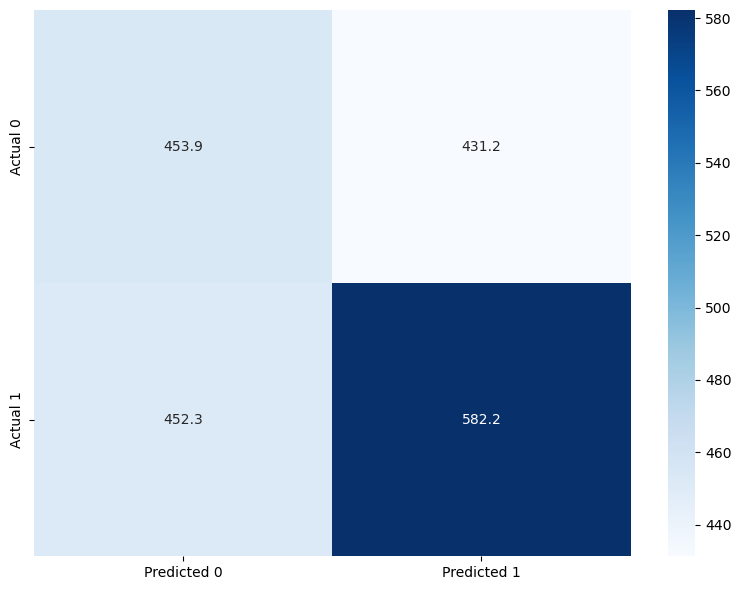

Top 20 most predictive features are: 
                       Features  Importance
1                         Theta    0.066637
84  occipital_hjorth_complexity    0.058051
68   temporal_hjorth_complexity    0.055724
60    central_hjorth_complexity    0.051888
39                     cD1_skew    0.047636
69      temporal_zero_crossings    0.046566
52    frontal_hjorth_complexity    0.046471
83    occipital_hjorth_mobility    0.046029
76   parietal_hjorth_complexity    0.043675
81   occipital_spectral_entropy    0.042736
2                         Alpha    0.041691
28                      cD4_RMS    0.041478
25                      cA4_RMS    0.041242
67     temporal_hjorth_mobility    0.038586
63             temporal_higuchi    0.037430
73    parietal_spectral_entropy    0.036940
80                occipital_DFA    0.035526
85     occipital_zero_crossings    0.035090
0                         Delta    0.034996
34                      cD2_RMS    0.034749



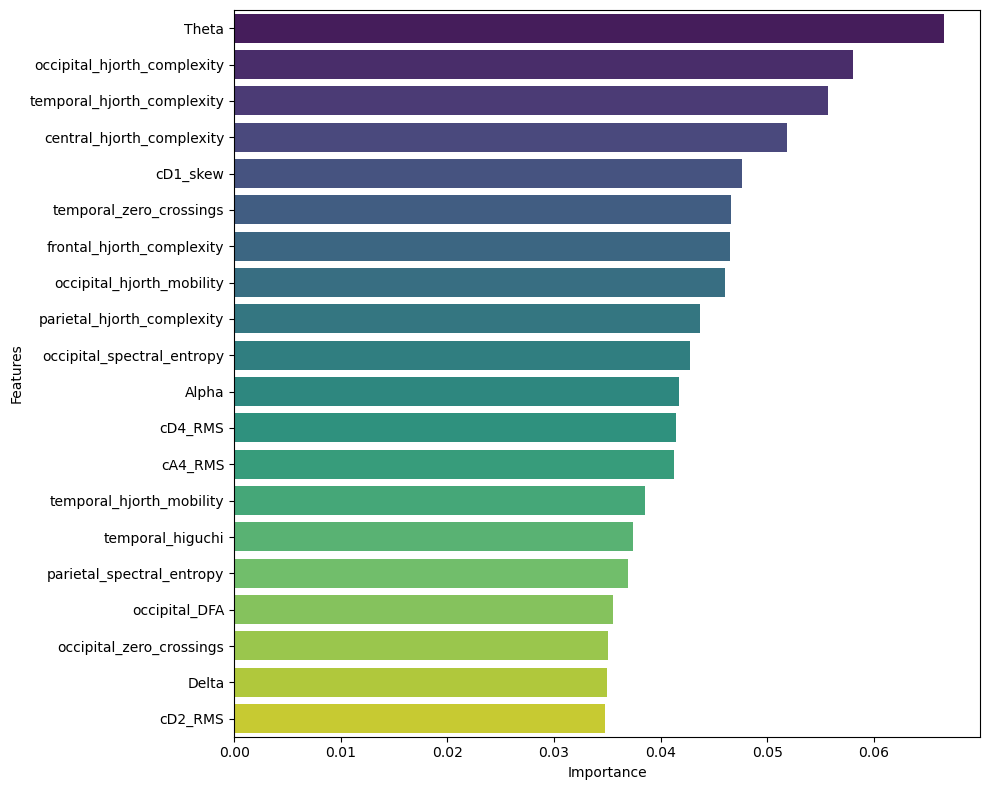

In [4]:
data = pd.read_csv("features_ICA_final.csv")
X = data.drop("target", axis="columns", inplace=False)
columns = X.columns



# LOGISTIC REGRESSION
print("LOGISTIC REGRESSION")
lr_results = pd.read_csv("aurometalsaurus/lr_results_ica_pca_final.csv")
# Display average metrics over all runs
print(f"Average accuracy: {np.mean(lr_results['accuracy'])}")
print(f"std accuracy: {np.std(lr_results['accuracy'])} \n")

print(f"Average precision: {np.mean(lr_results['precision'])}")
print(f"std precision: {np.std(lr_results['precision'])} \n")

print(f"Average recall: {np.mean(lr_results['recall'])}")
print(f"std recall: {np.std(lr_results['recall'])} \n")

print(f"Average F1: {np.mean(lr_results['f1'])}")
print(f"std F1: {np.std(lr_results['f1'])} \n")

# Plot average confusion matrix
lr_avg_conf_matrix = np.mean(
    np.array([
        lr_results["confusion_0_0"],
        lr_results["confusion_0_1"],
        lr_results["confusion_1_0"],
        lr_results["confusion_1_1"]
    ]),
    axis=1
).reshape(2, 2)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_avg_conf_matrix, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
# plt.title('Average Confusion Matrix Over 100 Iterations')
plt.tight_layout()
plt.show()



# Rank feature importances
lr_importances = np.array([
    np.array(list(map(float, imp.split(",")))) for imp in lr_results["feature_importances"]
])

lr_feature_importances = pd.DataFrame({
    "Features": columns, 
    "Importance": np.mean(np.abs(lr_importances), axis=0)
})
lr_feature_importances = lr_feature_importances.sort_values("Importance", ascending=False)
print(f"Top 20 most predictive features are: ")
print(lr_feature_importances.head(20))
print()

plt.figure(figsize=(10, 8))
sns.barplot(data=lr_feature_importances.head(20), x="Importance", y="Features", palette="viridis")
# plt.title("Top 20 Most Predictive Features (Mean Absolute Importance)")
plt.tight_layout()
plt.show()

RANDOM FOREST
Average accuracy: 0.5374969798375627
std accuracy: 0.10907266458361331 

Average precision: 0.5528801690071745
std precision: 0.12995865358999367 

Average recall: 0.5994907527430349
std recall: 0.14246804077098982 

Average F1: 0.5684065777524676
std F1: 0.1317654927998895 



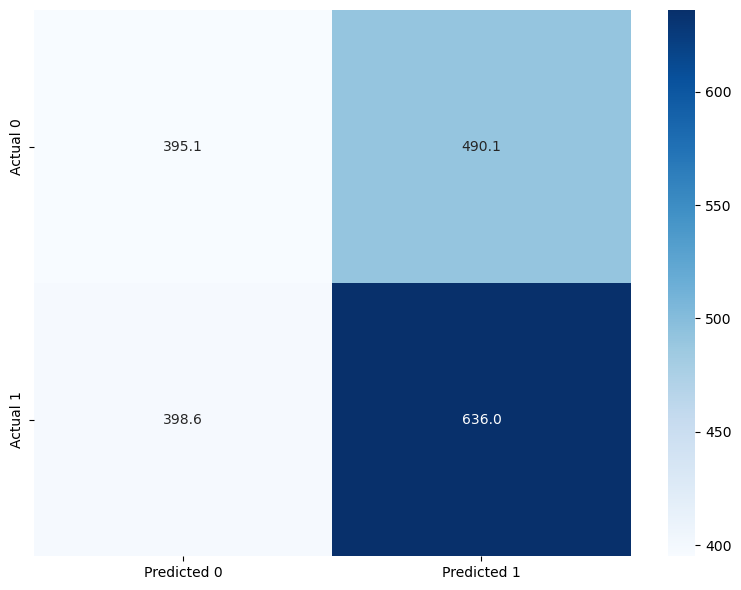

Top 20 most predictive features are: 
                        Features  Importance
3                           Beta    0.030540
46        frontal_sample_entropy    0.021503
51       frontal_hjorth_mobility    0.020048
67      temporal_hjorth_mobility    0.018973
53        frontal_zero_crossings    0.018279
62       temporal_sample_entropy    0.018079
2                          Alpha    0.017649
69       temporal_zero_crossings    0.016807
26                  cA4_kurtosis    0.016059
29                  cD4_kurtosis    0.015372
32                  cD3_kurtosis    0.015371
66  temporal_permutation_entropy    0.015141
63              temporal_higuchi    0.014822
34                       cD2_RMS    0.014525
55               central_higuchi    0.014407
28                       cD4_RMS    0.014406
25                       cA4_RMS    0.014406
31                       cD3_RMS    0.014219
20                    Beta/Gamma    0.013820
4                          Gamma    0.013752



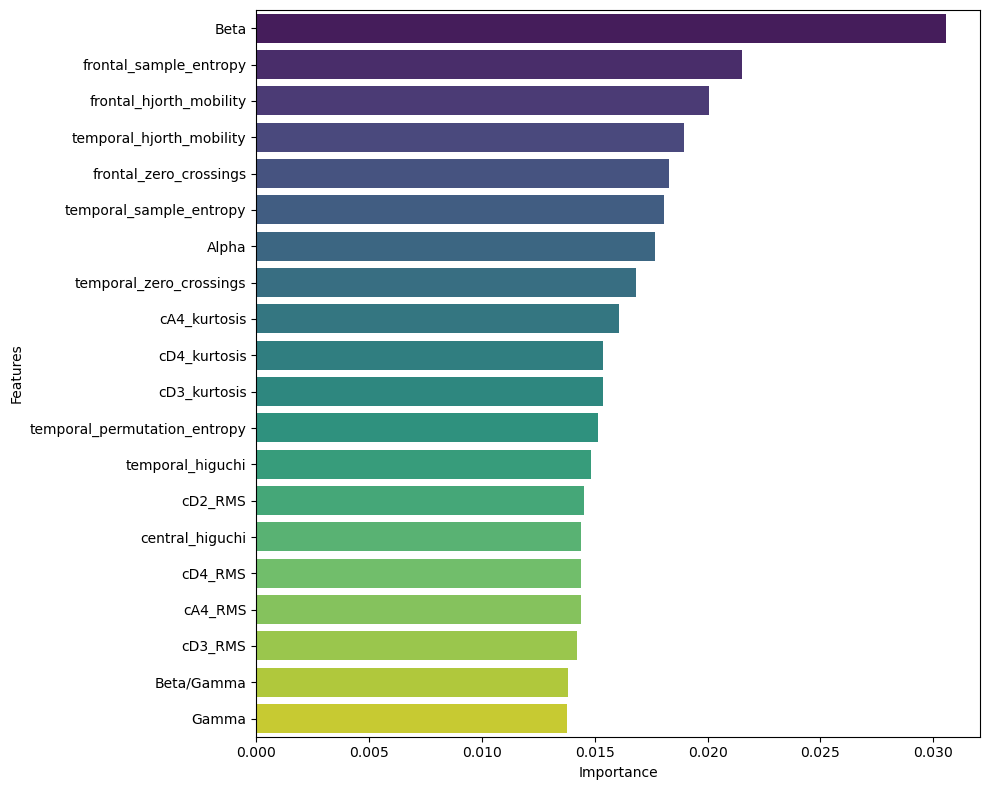

In [5]:
# Random Forest
print("RANDOM FOREST")
rf_results = pd.read_csv("aurometalsaurus/rf_results_ica_final.csv")
# Display average metrics over all runs
print(f"Average accuracy: {np.mean(rf_results['accuracy'])}")
print(f"std accuracy: {np.std(rf_results['accuracy'])} \n")

print(f"Average precision: {np.mean(rf_results['precision'])}")
print(f"std precision: {np.std(rf_results['precision'])} \n")


print(f"Average recall: {np.mean(rf_results['recall'])}")
print(f"std recall: {np.std(rf_results['recall'])} \n")

print(f"Average F1: {np.mean(rf_results['f1'])}")
print(f"std F1: {np.std(rf_results['f1'])} \n")

# Plot average confusion matrix
rf_avg_conf_matrix = np.mean(
    np.array([
        rf_results["confusion_0_0"],
        rf_results["confusion_0_1"],
        rf_results["confusion_1_0"],
        rf_results["confusion_1_1"]
    ]),
    axis=1
).reshape(2, 2)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_avg_conf_matrix, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
# plt.title('Average Confusion Matrix Over 100 Iterations')
plt.tight_layout()
plt.show()



# Rank feature importances
rf_importances = np.array([
    np.array(list(map(float, imp.split(",")))) for imp in rf_results["feature_importances"]
])

rf_feature_importances = pd.DataFrame({
    "Features": columns, 
    "Importance": np.mean(np.abs(rf_importances), axis=0)
})
rf_feature_importances = rf_feature_importances.sort_values("Importance", ascending=False)
print(f"Top 20 most predictive features are: ")
print(rf_feature_importances.head(20))
print()

plt.figure(figsize=(10, 8))
sns.barplot(data=rf_feature_importances.head(20), x="Importance", y="Features", palette="viridis")
# plt.title("Top 20 Most Predictive Features (Mean Absolute Importance)")
plt.tight_layout()
plt.show()

SVC
Average accuracy: 0.5460144626710765
std accuracy: 0.09859217355328753 

Average precision: 0.5516875760416989
std precision: 0.10272825757792162 

Average recall: 0.7675943869667995
std recall: 0.14154570895984936 

Average F1: 0.6311441176460556
std F1: 0.11705439058996123 



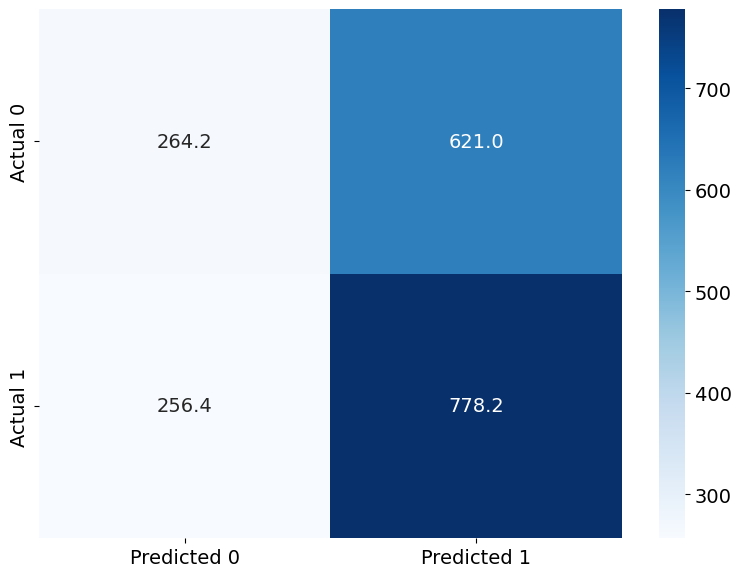

Top 20 most predictive features are: 
                       Features  Importance
38                 cD1_kurtosis    0.014441
39                     cD1_skew    0.013571
1                         Theta    0.013521
68   temporal_hjorth_complexity    0.011082
36                     cD2_skew    0.011007
84  occipital_hjorth_complexity    0.010649
29                 cD4_kurtosis    0.009159
26                 cA4_kurtosis    0.008902
0                         Delta    0.008420
37                      cD1_RMS    0.008166
83    occipital_hjorth_mobility    0.007801
44     global_hjorth_complexity    0.007748
52    frontal_hjorth_complexity    0.007302
85     occipital_zero_crossings    0.006936
40              wavelet_entropy    0.006848
32                 cD3_kurtosis    0.006821
67     temporal_hjorth_mobility    0.006818
35                 cD2_kurtosis    0.006622
60    central_hjorth_complexity    0.006570
76   parietal_hjorth_complexity    0.006415



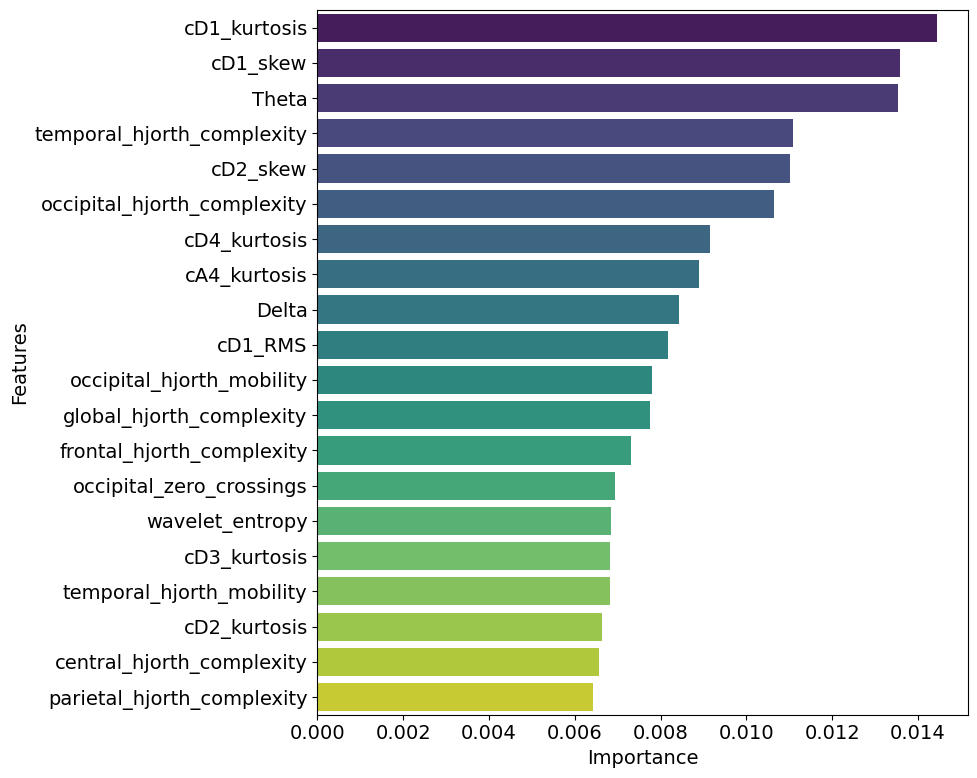

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SVC
print("SVC")
svc_results = pd.read_csv("aurometalsaurus/svc_results_ica_pca_final.csv")
# Display average metrics over all runs
print(f"Average accuracy: {np.mean(svc_results['accuracy'])}")
print(f"std accuracy: {np.std(svc_results['accuracy'])} \n")

print(f"Average precision: {np.mean(svc_results['precision'])}")
print(f"std precision: {np.std(svc_results['precision'])} \n")

print(f"Average recall: {np.mean(svc_results['recall'])}")
print(f"std recall: {np.std(svc_results['recall'])} \n")

print(f"Average F1: {np.mean(svc_results['f1'])}")
print(f"std F1: {np.std(svc_results['f1'])} \n")


# Plot average confusion matrix
svc_avg_conf_matrix = np.mean(
    np.array([
        svc_results["confusion_0_0"],
        svc_results["confusion_0_1"],
        svc_results["confusion_1_0"],
        svc_results["confusion_1_1"]
    ]),
    axis=1
).reshape(2, 2)
plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 14
sns.heatmap(svc_avg_conf_matrix, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
# plt.title('Average Confusion Matrix Over 100 Iterations')
plt.tight_layout()
plt.show()



# Rank feature importances
svc_importances = np.array([
    np.array(list(map(float, imp.split(",")))) for imp in svc_results["pi_means"]
])

svc_feature_importances = pd.DataFrame({
    "Features": columns, 
    "Importance": np.mean(np.abs(svc_importances), axis=0)
})
svc_feature_importances = svc_feature_importances.sort_values("Importance", ascending=False)
print(f"Top 20 most predictive features are: ")
print(svc_feature_importances.head(20))
print()

plt.figure(figsize=(10, 8))
sns.barplot(data=svc_feature_importances.head(20), x="Importance", y="Features", palette="viridis")
# plt.title("Top 20 Most Predictive Features (Mean Absolute Importance)")
plt.tight_layout()
plt.show()

### Feature importance exploration ###

In [7]:
lr_top = lr_feature_importances.head(20)["Features"]
rf_top = rf_feature_importances.head(20)["Features"]
svc_top = svc_feature_importances.head(20)["Features"]

# Convert to sets
lr_set = set(lr_top)
rf_set = set(rf_top)
svc_set = set(svc_top)

# Intersection of all three
lr_rf = lr_set & rf_set
rf_svc = rf_set & svc_set
lr_svc = lr_set & svc_set
all_three = lr_set & rf_set & svc_set

# Optional: Print or sort the intersection

print("Intersection of Top 20 Features Across lr_rf:")
print(sorted(lr_rf))
print(f"Total common features: {len(lr_rf)} \n")

print("Intersection of Top 20 Features Across rf_svc:")
print(sorted(rf_svc))
print(f"Total common features: {len(rf_svc)} \n")

print("Intersection of Top 20 Features Across lr_svc:")
print(sorted(lr_svc))
print(f"Total common features: {len(lr_svc)} \n")

print("Intersection of Top 20 Features Across All Models:")
print(sorted(all_three))
print(f"Total common features: {len(all_three)}")

Intersection of Top 20 Features Across lr_rf:
['Alpha', 'cA4_RMS', 'cD2_RMS', 'cD4_RMS', 'temporal_higuchi', 'temporal_hjorth_mobility', 'temporal_zero_crossings']
Total common features: 7 

Intersection of Top 20 Features Across rf_svc:
['cA4_kurtosis', 'cD3_kurtosis', 'cD4_kurtosis', 'temporal_hjorth_mobility']
Total common features: 4 

Intersection of Top 20 Features Across lr_svc:
['Delta', 'Theta', 'cD1_skew', 'central_hjorth_complexity', 'frontal_hjorth_complexity', 'occipital_hjorth_complexity', 'occipital_hjorth_mobility', 'occipital_zero_crossings', 'parietal_hjorth_complexity', 'temporal_hjorth_complexity', 'temporal_hjorth_mobility']
Total common features: 11 

Intersection of Top 20 Features Across All Models:
['temporal_hjorth_mobility']
Total common features: 1


# Statistical Tests #

In [10]:
f_statistic, p_value = f_oneway(lr_results["accuracy"], rf_results["accuracy"], svc_results["accuracy"])

print("Accuracy ANOVA")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

Accuracy ANOVA
F-statistic: 0.1756154533481248
P-value: 0.8390275854366075


In [11]:
f_statistic, p_value = f_oneway(lr_results["precision"], rf_results["precision"], svc_results["precision"])

print("Precision ANOVA")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

Precision ANOVA
F-statistic: 0.23431887632519724
P-value: 0.7912556190115019


In [12]:
f_statistic, p_value = f_oneway(lr_results["recall"], rf_results["recall"], svc_results["recall"])

print("Recall ANOVA")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

Recall ANOVA
F-statistic: 60.53312788731511
P-value: 8.900884472206289e-23


In [13]:
f_statistic, p_value = f_oneway(lr_results["f1"], rf_results["f1"], svc_results["f1"])

print("F1 ANOVA")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F1 ANOVA
F-statistic: 12.161272340759181
P-value: 8.386193358971892e-06


Recall Tukey's TSH
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    LR     RF   0.0586 0.0178 0.0082  0.109   True
    LR    SVC   0.2267    0.0 0.1763 0.2771   True
    RF    SVC   0.1681    0.0 0.1177 0.2185   True
--------------------------------------------------


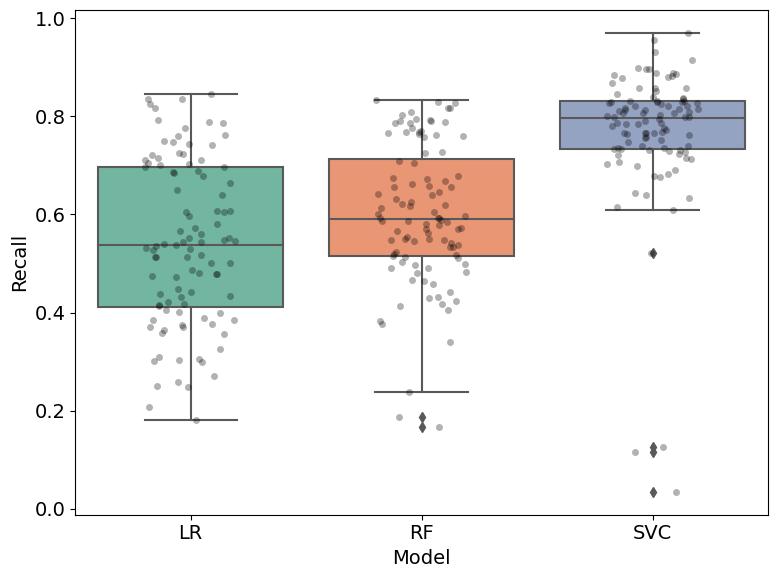

In [16]:
# Combine recall values and labels
full_recall = pd.concat([lr_results["recall"], rf_results["recall"], svc_results["recall"]], ignore_index=True)
model_labels = (["LR"] * len(lr_results)) + (["RF"] * len(rf_results)) + (["SVC"] * len(svc_results))

df_recall = pd.DataFrame({
    "Recall": full_recall,
    "Model": model_labels
})

# Tukey HSD test
tukey_result = pairwise_tukeyhsd(endog=df_recall["Recall"], groups=df_recall["Model"], alpha=0.05)
print("Recall Tukey's TSH")
print(tukey_result)


# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_recall, x="Model", y="Recall", palette="Set2")
sns.stripplot(data=df_recall, x="Model", y="Recall", color='black', alpha=0.3, jitter=0.2)

# plt.title("Recall Scores by Model with Tukey HSD Comparison")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()

F1 Tukey's HSD
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    LR     RF   0.0277 0.3042 -0.0165  0.072  False
    LR    SVC   0.0905    0.0  0.0462 0.1347   True
    RF    SVC   0.0627 0.0027  0.0185  0.107   True
---------------------------------------------------


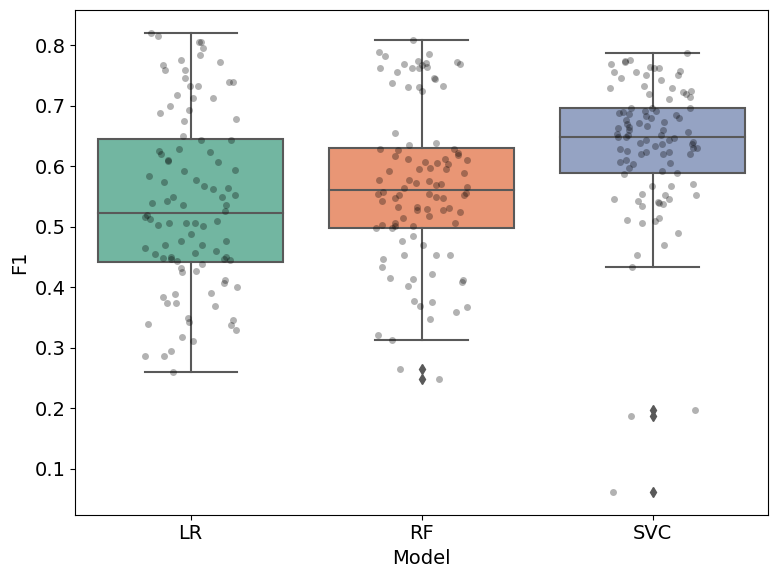

In [17]:
# Combine recall values and labels
full_f1 = pd.concat([lr_results["f1"], rf_results["f1"], svc_results["f1"]], ignore_index=True)
model_labels = (["LR"] * len(lr_results)) + (["RF"] * len(rf_results)) + (["SVC"] * len(svc_results))

df_recall = pd.DataFrame({
    "F1": full_f1,
    "Model": model_labels
})

# Tukey HSD test
tukey_result = pairwise_tukeyhsd(endog=df_recall["F1"], groups=df_recall["Model"], alpha=0.05)
print("F1 Tukey's HSD")
print(tukey_result)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_recall, x="Model", y="F1", palette="Set2")
sns.stripplot(data=df_recall, x="Model", y="F1", color='black', alpha=0.3, jitter=0.2)

# plt.title("F1 Scores by Model with Tukey HSD Comparison")
plt.ylabel("F1")
plt.tight_layout()
plt.show()